# Natural Scenery Image Classification

## Table of Contents

1. **[About Dataset](#about_dataset)**
2. **[Objective](#objective)**
3. **[Pre-processing the Data](#data_preprocessing)**
    - 3.1 - [Importing Common Data Handling & Processing Libraries](#importing_common_libs)
    - 3.2 - [Building Training and Validation Dataframes](#building_train_validation_sets)
    - 3.3 - [Data Augmentation](#data_augmentation)
    - 3.4 - [Generating Batches of the Augmented Data](#generating_batches)
4. **[The InceptionNetV3 model](#model_description)**
5. **[Building the Model](#model_building)**
    - 5.1 - [Defining the InceptionNetV3 Model](#model_definition)
    - 5.2 - [Compiling the Model](#model_compilation)
    - 5.3 - [Creating a Model Checkpoint](#model_checkpoint)
    - 5.4 - [Setting Seeds to Ensure Repeatable Results](#setting_seeds)
    - 5.5 - [Fitting the Model on the Data](#model_fitting)
6. **[Evaluating the Model](#model_evaluation)**
    - 6.1 - [Plotting Training and Validation Accuracy](#plotting_accuracy)
    - 6.1 - [Plotting Training and Validation Loss](#plotting_loss)
    - 6.1 - [Loading the Most Accurate Model](#loading_model)
    - 6.1 - [Plotting a Confusion Matrix](#confusion_matrix)
    - 6.1 - [Printing the Classification Report](#classification_report)
    - 6.1 - [Evaluating the Validation Loss and Accuracy](#evaluation_scores)

<a id='about_dataset'></a>
## About Dataset:
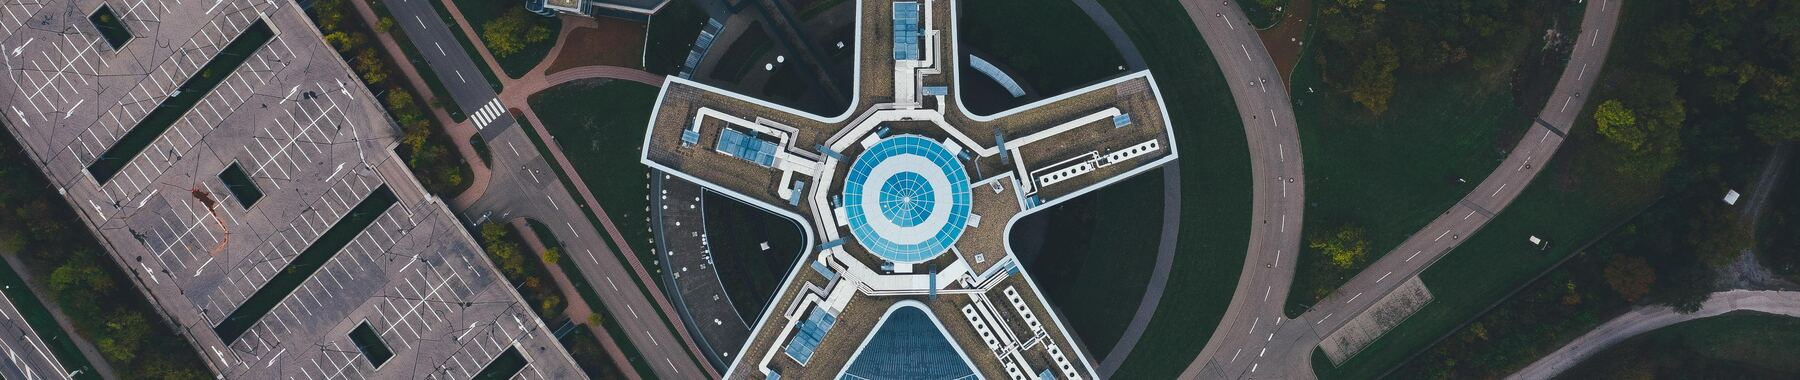
    
This dataset contains images of natural scenes from around the world. There are a total of 25K images of size 150x150 divided into 6 categories: Buildings, Forests, Glaciers, Mountains, Sea and Streets. This dataset was initially published on https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/#About by Intel to host a Image classification Challenge.

<a id='objective'></a>
## Objective:
The objective of the project is to build a model that can classify the images of natural scenery into appropriate categories (Buildings, Forests, Glaciers, Mountains, Sea and Streets).

<a id='data_preprocessing'></a>
## Pre-processing the Data:

<a id='importing_common_libs'></a>
### Importing Common Data Handling and Processing Libraries:

In [1]:
import numpy as np
import pandas as pd

<a id='building_train_validation_sets'></a>
### Building Training and Validation Dataframes:
These dataframes consist of image paths and the correspoding image labels.

In [2]:
import os

labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def dataframer(base_dir):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
      label_path = os.path.join(base_dir, img_class)
      if img_class in labels:
        for img in os.listdir(label_path):
          path.append(os.path.join(label_path, img))
          label.append(img_class)
    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data
            
train_base_dir = r"C:\Vishnu Vardhan\CS\Data Science\Imarticus Data Analytics & ML\Projects\Natural Scenery Image Classification\data\seg_train\seg_train"
validation_base_dir = r"C:\Vishnu Vardhan\CS\Data Science\Imarticus Data Analytics & ML\Projects\Natural Scenery Image Classification\data\seg_test\seg_test"

train_img_data = dataframer(train_base_dir)
validation_img_data = dataframer(validation_base_dir)

In [3]:
train_img_data.sample(5)

,Path,Label
13755,/kaggle/input/intel-image-classification/seg_t...,glacier
13782,/kaggle/input/intel-image-classification/seg_t...,glacier
9214,/kaggle/input/intel-image-classification/seg_t...,sea
5788,/kaggle/input/intel-image-classification/seg_t...,buildings
2579,/kaggle/input/intel-image-classification/seg_t...,street


In [4]:
validation_img_data.sample(5)

,Path,Label
2980,/kaggle/input/intel-image-classification/seg_t...,glacier
1961,/kaggle/input/intel-image-classification/seg_t...,sea
2622,/kaggle/input/intel-image-classification/seg_t...,glacier
1748,/kaggle/input/intel-image-classification/seg_t...,sea
2210,/kaggle/input/intel-image-classification/seg_t...,forest


<a id='data_augmentation'></a>
### Data Augmentation:
We augment the data using the 'Image Data Generator' function from the Keras preprocessing library. It allows various augmentation techniques such as rescaling, zooming, horizontal/vertical flipping, etc.

In [5]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1/255,
    zoom_range = 0.1,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

<a id='generating_batches'></a>
### Generating Batches of the Augmented Data:

In [6]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_img_data,
    x_col = "Path",
    y_col = "Label",
    target_size = (150,150),
    batch_size = 1024,
    class_mode = "categorical",
    subset = "training",
    shuffle = True,
    seed = 10
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_img_data,
    x_col = "Path",
    y_col = "Label",
    target_size = (150,150),
    batch_size = 256,
    class_mode = "categorical",
    shuffle = False
)

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


<a id='model_description'></a>
## The InceptionNet Model:

The InceptionNet model is an advanced Convolutional Neural Network (CNN). The most straightforward way to improve performance on CNNs is to use more layers. Yet, in practice, simply adding more layers tends to yield lower accuracies due to vanishing or exploding gradients. The InceptionNet model solves this by using 'inception modules'. The idea of an inception module is that it extracts features of various sizes from the images using convolution layers of different sizes (from the most accurate detailing (1x1) to a larger scale (5x5)) in parallel.

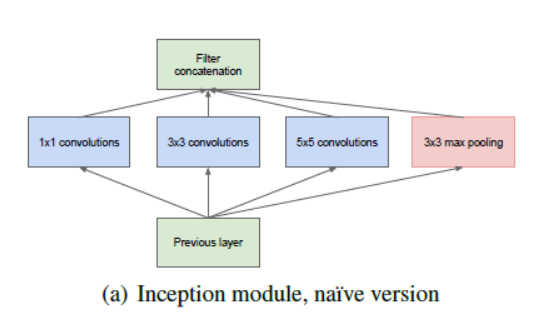

The 1x1 convolutions allow us to analyse the image at a pixel resolution without creating too many additional model parameters.  
Here’s the full architecture comprising of all 9 Inception modules:

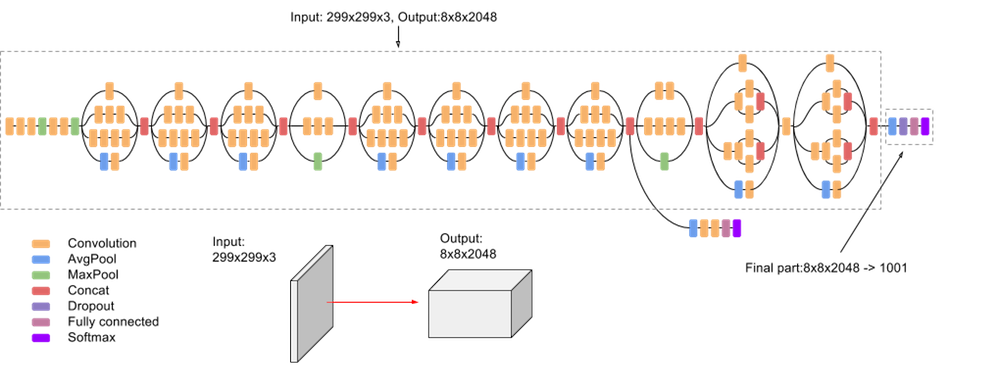

<a id='model_building'></a>
## Building the Model:

<a id='model_definition'></a>
### Defining the InceptionNetV3 Model:

In [7]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential

#Creating an instance of the InceptionNetV3 model using imagenet weights:
inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

#Defining all layers except the last 5 as non-trainable:
for layer in inception.layers[:-5]:
    layer.trainable = False

#Sequential model with layers of aforementioned InceptionNetV3 model 
#followed by a pooling layer, flattening layer and 4 dense layers:
inception_model = Sequential([
        inception,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation = "relu"),
        Dense(128, activation = "relu"),
        Dense(64, activation = "relu"),
        Dense(6, activation = 'softmax')
    ])

inception_model.summary()

2022-11-07 14:29:32.371331: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________

<a id='model_compilation'></a>
### Compiling the Model:
Here we define the optimization method along with loss and metrics parameters.

In [8]:
inception_model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

<a id='model_checkpoint'></a>
### Creating a Model Checkpoint:
Creating a model checkpoint allows us to recover the more accurate verison of the model over all the epochs of fitting the model on the data.

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(r'C:\Vishnu Vardhan\CS\Data Science\Imarticus Data Analytics & ML\Projects\Natural Scenery Image Classification\models\inception.hdf5', 
                             monitor = 'val_accuracy', save_best_only = True)

<a id='setting_seeds'></a>
### Setting Seeds to Ensure Repeatable Results:

In [10]:
import random as rd

rd.seed(150)
np.random.seed(150)
tf.random.set_seed(150)

<a id='model_fitting'></a>
### Fitting the Model on the Data:

In [11]:
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch = 10,
    validation_data = validation_generator,
    validation_steps = 5,
    epochs = 20,
    callbacks = [checkpoint])

2022-11-07 14:29:49.015481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
10/10 [==============================] - 285s 27s/step - loss: 1.3881 - accuracy: 0.5140 - val_loss: 0.5842 - val_accuracy: 0.7984
Epoch 2/20
10/10 [==============================] - 252s 25s/step - loss: 0.5316 - accuracy: 0.8422 - val_loss: 0.5801 - val_accuracy: 0.7969
Epoch 3/20
10/10 [==============================] - 249s 24s/step - loss: 0.3988 - accuracy: 0.8637 - val_loss: 0.5131 - val_accuracy: 0.8055
Epoch 4/20
10/10 [==============================] - 254s 25s/step - loss: 0.3607 - accuracy: 0.8763 - val_loss: 0.3783 - val_accuracy: 0.8523
Epoch 5/20
10/10 [==============================] - 248s 25s/step - loss: 0.3144 - accuracy: 0.8911 - val_loss: 0.2902 - val_accuracy: 0.8930
Epoch 6/20
10/10 [==============================] - 247s 25s/step - loss: 0.3067 - accuracy: 0.8942 - val_loss: 0.2889 - val_accuracy: 0.9047
Epoch 7/20
10/10 [==============================] - 248s 24s/step - loss: 0.2919 - accuracy: 0.8961 - val_loss: 0.2815 - val_accuracy: 0.8945
Epoch 

<a id='model_evaluation'></a>
## Evaluating the Model:

<a id='plotting_accuracy'></a>
### Plotting Training and Validation Accuracy:

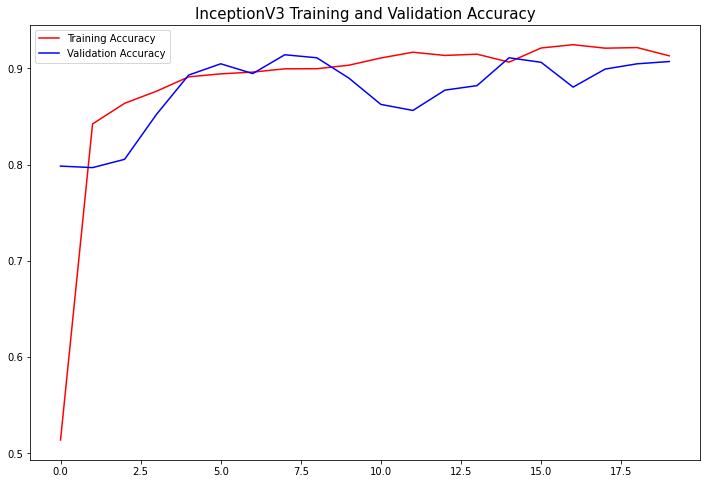

In [12]:
import matplotlib.pyplot as plt

inception_acc = inception_history.history['accuracy']
inception_val_acc = inception_history.history['val_accuracy']

epochs = range(len(inception_acc))

plt.figure(figsize = (12, 8))
plt.plot(epochs, inception_acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, inception_val_acc, 'b', label = 'Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy', fontsize = 15)
plt.legend(loc = 0)

plt.show()

<a id='plotting_loss'></a>
### Plotting Training and Validation Loss:

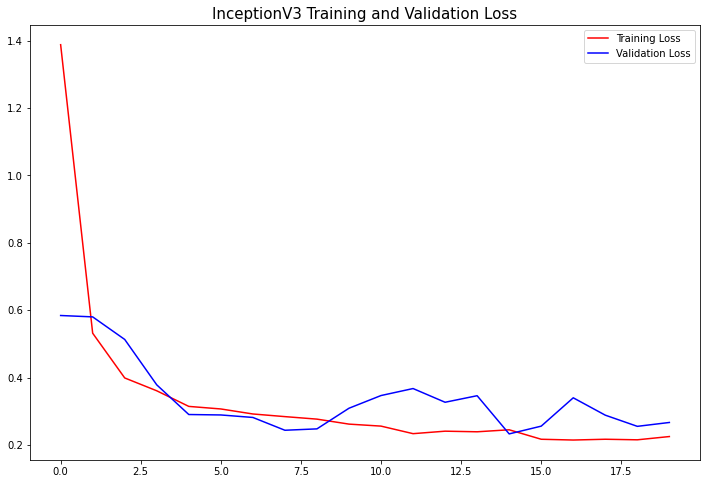

In [13]:
inception_loss = inception_history.history['loss']
inception_val_loss = inception_history.history['val_loss']

epochs = range(len(inception_loss))

plt.figure(figsize = (12, 8))
plt.plot(epochs, inception_loss, 'r', label = 'Training Loss')
plt.plot(epochs, inception_val_loss, 'b', label = 'Validation Loss')
plt.title('InceptionV3 Training and Validation Loss', fontsize = 15)
plt.legend(loc = 0)

plt.show()

<a id='loading_model'></a>
### Loading the Most Accurate Model:

In [14]:
from keras.models import load_model

inception_model = load_model(r'C:\Vishnu Vardhan\CS\Data Science\Imarticus Data Analytics & ML\Projects\Natural Scenery Image Classification\models\inception.hdf5')

<a id='confusion_matrix'></a>
### Plotting a Confusion Matrix:

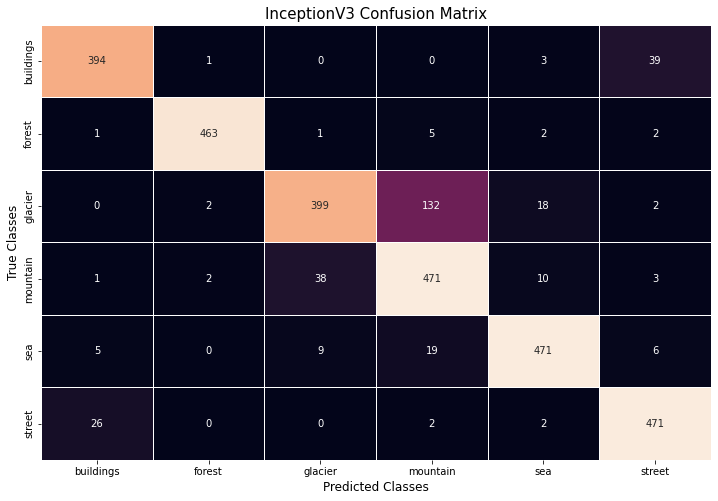

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred_inception = inception_model.predict(validation_generator)
y_pred_inception = np.argmax(Y_pred_inception, axis = 1)

inception_confusion_matrix = confusion_matrix(validation_generator.classes, y_pred_inception)
conf_matrix = pd.DataFrame(data = inception_confusion_matrix, columns = labels, index = labels)

plt.figure(figsize = (12, 8))
sns.heatmap(conf_matrix, annot = True, cbar = False, fmt = 'd', linewidth = 0.5)
plt.xlabel('Predicted Classes', fontsize = 12)
plt.ylabel('True Classes', fontsize = 12)
plt.title('InceptionV3 Confusion Matrix', fontsize = 15)
plt.show()

**It is clear that most of the classification inaccuracy comes from misclasification between glaciers and mountains as well as buildings and streets.**

<a id='classification_report'></a>
### Printing the Classification Report:

In [16]:
print('InceptionV3 Classification Report')
print(classification_report(validation_generator.classes, y_pred_inception, target_names = labels))

InceptionV3 Classification Report
              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       437
      forest       0.99      0.98      0.98       474
     glacier       0.89      0.72      0.80       553
    mountain       0.75      0.90      0.82       525
         sea       0.93      0.92      0.93       510
      street       0.90      0.94      0.92       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



<a id='evaluation_scores'></a>
### Evaluating the Validation Loss and Accuracy:

In [17]:
result = inception_model.evaluate(validation_generator, batch_size = 300)
print("Validation Loss & Accuracy on InceptionV3:", result)

12/12 [==============================] - 60s 5s/step - loss: 0.2908 - accuracy: 0.8897
Validation Loss & Accuracy on InceptionV3: [0.29077139496803284, 0.8896666765213013]
